# Clinical Trials Data Processing

## Goal

- To get a basic data processing pipeline outlined 
- To get the results we need to build a MVP 
- To understand future steps for more advanced study p

## TODOS
- Compare results filtering with the number of results from the GUI
- Parse all studies into workable CSVs with certain attributes 
- Create a safe method for getting values from the JSON file withought killin the study 
- Add in objective flags for measurement types
- Get the P-Values with the other types
- Add in the demographics to the csv
- Look at the missed values and see if the studies are really missing data 


In [1]:
# I think we just need to get all the studies and filter out the ones with results manually 
# We can make a module for this later
# The conditions can be easily parsed but we need to bucket them -> maybe make a model for that??
# The demographics are the easiest to get out of this
# Effectiveness - this can be done by averaging the difference between placebo and results, thought we 
# first have to filter the studies that have a placebo 
#
# Fields to be 

In [2]:
import requests
import pandas as pd
import scipy.stats as stats 

API_BASE_URL='https://clinicaltrials.gov/api/query'
EXAMPLE_DRUG='gabapentin'

### Interfacing with ClinicalTrials.gov
- TODO: need to get all the studies not just the ones in a certain range 
- It's also worth noting that we can download all of this data

In [3]:
# First a basic API interface

def get_studies_by_expression(expression):
    r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk=1&max_rnk=99&fmt=json'
                     .format(expr=expression))
    return r.json()

def get_conditions_for_drug(drug):
    r = requests.get(API_BASE_URL + '/field_values?expr={drug}&field=ConditionAncestorTerm&fmt=json'
                     .format(drug=drug))
    
    return r.json()

In [4]:
def get_all_studies(expr, results=True):
    og_length = 99
    studies = []
    count = 0
    while (og_length >= 99):
        r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk={min_rank}&max_rnk={max_rank}&fmt=json'
                         .format(expr=expr, min_rank=count*99 + 1, max_rank=(count*99+1)+98))
        og_length = len(r.json()['FullStudiesResponse'].get('FullStudies', []))
        new_studies = r.json()['FullStudiesResponse'].get('FullStudies', [{'Study': []}])
        studies += list(filter(lambda x: 'ResultsSection' in x['Study'] and 'OutcomeMeasuresModule' in x['Study']['ResultsSection'], new_studies))
        count+=1
        
    return studies


## Conditions

### Consolidate the Conditions Data

- Need to get all the conditions in a formatted dataframe to parse the other results

- TODO: the AncestorConditions are too broad and the normal conditions are too specific -> we need our own 
method for this


In [5]:
raw_conditions_dict = get_conditions_for_drug('gabapentin') 

In [6]:
condition_field_values = raw_conditions_dict['FieldValuesResponse']['FieldValues']

In [7]:
parsable = {'Conditions': [], 'NStudies': []}
for value in condition_field_values:
    parsable['Conditions'].append(value['FieldValue'])
    parsable['NStudies'].append(value['NStudiesFoundWithValue'])

conditionsDf = pd.DataFrame.from_dict(parsable).sort_values('NStudies', ascending=False)
conditionsDf

,Conditions,NStudies
183,Neurologic Manifestations,200
176,Nervous System Diseases,173
198,Pain,155
203,Pathologic Processes,122
184,Neuromuscular Diseases,85
...,...,...
120,Infertility,1
121,"Infertility, Male",1
122,Inflammatory Bowel Diseases,1
123,Intellectual Disability,1


### Exploratory Statistics 
- Let's get a better feel for the conditions here 

In [8]:
conditionsDf.head(20)


,Conditions,NStudies
183,Neurologic Manifestations,200
176,Nervous System Diseases,173
198,Pain,155
203,Pathologic Processes,122
184,Neuromuscular Diseases,85
150,Mental Disorders,82
213,Postoperative Complications,68
207,Peripheral Nervous System Diseases,62
160,Musculoskeletal Diseases,44
246,Sleep Wake Disorders,40


<AxesSubplot:>

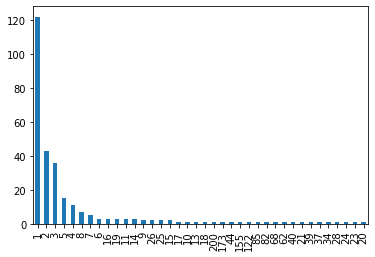

In [9]:
import matplotlib.pyplot as plt

conditionsDf['NStudies'].value_counts().plot.bar()

In [10]:
# We need to get a cutoff value for what conditions are going to be listed 
# The value should be percentage based to account for the differing study values for each drug
# Maybe the conditions that add up to 50% of the data or something 
# Actually let's just take top 5 - this is a problem for the medical people

conditionsDf.sum()['NStudies']

2189

In [11]:
count = 0
curr_sum = 0
total_sum = conditionsDf.sum()['NStudies']
for i in range(len(conditionsDf)):
    if curr_sum / total_sum > .1:
        break
    
    curr_sum += conditionsDf['NStudies'][i]
    count += 1


## Study Processing

- Filter out useless studies san results 
- Parse out useful values from the tree: place
- Create a dataframe for the other aspects of drug 

In [12]:
# Get all studies for all conditions for a given drug
# studies = []
# for condition in conditionsDf[0:3]['Conditions'].tolist():
#     print(EXAMPLE_DRUG + ' AND AREA[ConditionAncestorTerm]{}'.format(condition))
#     studies += get_all_studies(EXAMPLE_DRUG + ' AND AREA[ConditionAncestorTerm]{}'.format(condition))
    

### Parsing data
- Need to reduce the attrition rate for all the studies
- Let's get all the following into a csv -> a function for each

In [ ]:
# Get all studies relating to Gabapentin 
studies = get_all_studies(EXAMPLE_DRUG)
len(studies)

In [ ]:
# Base dataframe with raw sections


#### Placebo Group
The control or placebo group that gets nothing 
- Name
- Original JSON
- Description 
- Number of participants 
- Demographics

In [96]:
# Get a list of all the outcome modules

def get_outcome_modules(studies):
    outcome_modules = []
    for study in studies:
        if 'OutcomeMeasuresModule' in study['Study']['ResultsSection']:
            outcome_modules.append(study['Study']['ResultsSection']['OutcomeMeasuresModule'])
            continue 
        print('No Results: ', study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        
    return outcome_modules

outcome_modules = get_outcome_modules(studies)

In [115]:
# Get all the names used for groups
def parse_outcome_modules(outcomes):
    outcome_df = {'groups': [], 'outcome_measures': []}
    for outcome in outcomes:
        try: 
            outcome_df['outcome_measures'].append(outcome['OutcomeMeasureList']['OutcomeMeasure'])
        except KeyError as e:
            outcome_df['outcome_measures'].append('NA')
                  
        try: 
            outcome_df['groups'].append([x['OutcomeGroupList']['OutcomeGroup'] for x in outcome['OutcomeMeasureList']['OutcomeMeasure']])
        except KeyError as e:
            outcome_df['groups'].append('NA')
                  
    return outcome_df
            
outcomes = pd.DataFrame.from_dict(parse_outcome_modules(outcome_modules))
outcomes['name'] = pd.Series((study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'] for study in studies))




In [139]:
outcomes['primary_measures'] = outcomes['outcome_measures'].apply(lambda x: [y for y in x if y['OutcomeMeasureType'] == 'Primary'])
outcomes['secondary_measures'] = outcomes['outcome_measures'].apply(lambda x: [y for y in x if y['OutcomeMeasureType'] == 'Secondary'])



In [143]:
outcomes['primary_groups'] = outcomes['primary_measures'].apply(lambda x: [y['OutcomeGroupList']['OutcomeGroup'] for y in x])
outcomes['secondary_groups'] = outcomes['secondary_measures'].apply(lambda x: [y['OutcomeGroupList']['OutcomeGroup'] for y in x])



A look at the number of outcome measurements and groups

The data is nested and very complex

,groups,outcome_measures,name,no_primary,no_secondary,no_other,no_total,no_groups,group_titles,primary_measures,secondary_measures,primary_groups,secondary_groups
0,"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","A Phase II, Randomized, Placebo-controlled, Do...",1,1,0,2,2,"[Gabapentin, Placebo, Gabapentin, Placebo]","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","[{'OutcomeMeasureType': 'Secondary', 'OutcomeM...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit..."
1,"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...",Administration of Pre-Operative Gabapentin to ...,1,2,0,3,3,"[Gabapentin, Placebo, Gabapentin, Placebo, Gab...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","[{'OutcomeMeasureType': 'Secondary', 'OutcomeM...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit..."
2,"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...",Pain Control in Pediatric Posterior Spine Fusi...,1,1,0,2,2,"[Gabapentin, Simple Syrup, Gabapentin, Simple ...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","[{'OutcomeMeasureType': 'Secondary', 'OutcomeM...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit..."
3,"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","Open Labeled, Non-randomized, Study of Efficac...",1,3,1,5,5,"[Gralise (Gabapentin ER), Gralise (Gabapentin ...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","[{'OutcomeMeasureType': 'Secondary', 'OutcomeM...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit..."
4,"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...",Gabapentin for Smoking Abstinence,1,0,0,1,1,"[Placebo, Gabapentin - 1800 mg /Day, Gabapenti...","[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...",[],"[[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTit...",[]


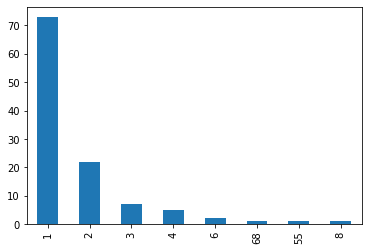

In [144]:

# There are way more measures than when I first thought - we need to add a priamry/secondary outcome tab
# and put them in a parsed format
outcomes['no_primary'] = outcomes['primary_measures'].apply(len)
outcomes['no_secondary'] = outcomes['secondary_measures'].apply(len)
outcomes['no_other'] = outcomes['outcome_measures'].apply(lambda x: len([y for y in x if y['OutcomeMeasureType'] == 'Other Pre-specified']))
outcomes['no_total'] = outcomes['outcome_measures'].apply(len)
outcomes['no_groups'] = outcomes['groups'].apply(len)


outcomes['no_primary'].value_counts(sort=True).plot.bar()
outcomes.head()


Getting out the primary, secondary, and other measures out in a good way is difficult
We need specific values in those groups
 - Placebo group id 
 - Drug group id 
 - Descriptions of the above 
 - Outcome param type 
 - Outcome range type
 - Dosage 
 
Essentially everything - we will continue focusing on the placebo group id.

We need to enumerate all the possible ways placebo groups are identified and account for them all

Unfortunately - we need to label the data to get our error rate for identifyign the placebo group

In [148]:
# Get all fields that have values that look like groups 

def get_group_titles(groups):
    titles = []
    for group in groups:
        for ind in group:
            if 'OutcomeGroupTitle' in ind:
                titles.append(ind['OutcomeGroupTitle'])
                continue
            print(ind)
            
    return titles

titles = outcomes['primary_groups'].apply(get_group_titles).tolist()
unique_titles = pd.Series([item for sublist in titles for item in sublist]).value_counts().index.tolist() # These need to be primary for sure


In [167]:
counts = {}
for i, unique in enumerate(unique_titles):
    if i not in counts:
        counts[i] = [unique, 0]
    for group in titles:
        if unique in group:
            counts[i][1] += 1
    

counts = pd.DataFrame.from_dict(counts, orient='index')
counts

,0,1
0,Methotrexate (MTX) + Tofacitinib: MTX Persistent,1
1,Methotrexate (MTX) + Tofacitinib: MTX Disconti...,1
2,Methotrexate (MTX) + Tofacitinib: MTX Interrupted,1
3,Gabapentin,42
4,Placebo,37
...,...,...
183,+EIASD Level 3 (1700 mg/dayx5D),1
184,Group 1: Placebo,1
185,"Medicaid, Uncontrolled, Subgroup",1
186,All Antiepileptic Drugs,1


In [176]:
counts[counts[0].str.lower().str.contains('placebo')]

,0,1
4,Placebo,37
40,Placebo/Morphine,1
45,Active Placebo,1
46,GEn Placebo,1
49,Placebo Oral Capsule,3
55,3 Preoperative and Postoperative Placebo Liquid,1
58,Placebo Cream and Capsules,1
59,High CIWAar Placebo,1
65,"Amitriptyline 4% Ketamine 2% Cream, Placebo Ca...",1
71,1 Placebo,1


In [15]:
def append_buffer_to_dfdict(buffer, df_dict):
    for k, v in buffer.items():
        df_dict[k]+=v
    

In [16]:
# Let's get this study into a big dataframe 
# TODO: we need catches for if these all error out 
# I think the plan is to create a buffer dict and if that dict completes add it 

df_dict = {'id': [], 'name': [], 'outcome_groups':[], 'drug': [], 'conditions': [], 
           'primary_outcomes': [], 'verified_date': [], 'responsible_party': [], 'type': [], 
           'type_description': [], 'outcome_measure':  [], 'outcome_spread': [], 
           'outcome_measure_param': [], 'outcomes': [], 'outcome_subjects': []
          }

for i, study in enumerate(studies):
    buffer = {'id': [], 'name': [], 'outcome_groups':[], 'drug': [], 'conditions': [], 
              'primary_outcomes': [], 'verified_date': [], 'responsible_party': [], 'type': [], 
              'type_description': [], 'outcome_measure':  [], 'outcome_spread': [], 
              'outcome_measure_param': [], 'outcomes': [], 'outcome_subjects': []
             }
    
    
    buffer['drug'].append(EXAMPLE_DRUG)
    try:
        buffer['id'].append(study['Study']['ProtocolSection']['IdentificationModule']['NCTId'])
    except KeyError as e:
        buffer['id'].append('NA')
    
    try:
        buffer['name'].append(study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
    except KeyError as e:
        buffer['name'].append('NA')
        
    try:
        buffer['verified_date'].append(study['Study']['ProtocolSection']['StatusModule']['StatusVerifiedDate'])
    except KeryError as e:
        buffer['verified_date'].append('NA')
        
    try:
        buffer['responsible_party'].append(study['Study']['ProtocolSection']['SponsorCollaboratorsModule']['ResponsibleParty'])
    except KeyError as e:
        buffer['responsible_party'].append('NA')
        
    try: 
        buffer['conditions'].append(study['Study']['ProtocolSection']['ConditionsModule']['ConditionList']['Condition'])
    except KeyError as e:
        buffer['conditions'].append('NA')
        
    try:
        buffer['type'].append(study['Study']['ProtocolSection']['DesignModule']['DesignInfo']['DesignInterventionModel'])
    except KeyError as e:
        buffer['type'].append('NA')
        
    try:
        buffer['type_description'].append(study['Study']['ProtocolSection']['DesignModule']['DesignInfo'].get('DesignInterventionModelDescription', ''))
    except KeyError as e:
        buffer['type_description'].append('NA')
        
    try:
        buffer['primary_outcomes'].append(study['Study']['ProtocolSection']['OutcomesModule']['PrimaryOutcomeList']['PrimaryOutcome'])
    except KeyError as e:
        buffer['primary_outcomes'].append('NA')
        
    try:
        buffer['outcome_groups'].append(study['Study']['ResultsSection']['OutcomeMeasuresModule']['OutcomeMeasureList']['OutcomeMeasure'][0]['OutcomeGroupList']['OutcomeGroup'])
    except KeyError as e:
        buffer['outcome_groups'].append('NA')
        
    try:
        buffer['outcome_measure'].append(study['Study']['ResultsSection']['OutcomeMeasuresModule']['OutcomeMeasureList']['OutcomeMeasure'][0]['OutcomeMeasureTitle'])
    except KeyError as e:
        buffer['outcome_measure'].append('NA')
        
    try:
        buffer['outcome_spread'].append(study['Study']['ResultsSection']['OutcomeMeasuresModule']['OutcomeMeasureList']['OutcomeMeasure'][0].get('OutcomeMeasureDispersionType', ''))
    except KeyError as e:
        buffer['outcome_spread'].append('NA')
        
    try:
        buffer['outcome_measure_param'].append(study['Study']['ResultsSection']['OutcomeMeasuresModule']['OutcomeMeasureList']['OutcomeMeasure'][0].get('OutcomeMeasureParamType', ''))
    except KeyError as e:
        buffer['outcome_measure_param'].append('NA')
        
    try:
        buffer['outcomes'].append(study['Study']['ResultsSection']['OutcomeMeasuresModule']['OutcomeMeasureList']['OutcomeMeasure'][0].get('OutcomeClassList', ''))
    except KeyError as e:
        buffer['outcomes'].append('NA')
    
    try:
        buffer['outcome_subjects'].append(study['Study']['ResultsSection']['OutcomeMeasuresModule']['OutcomeMeasureList']['OutcomeMeasure'][0].get('OutcomeDenomList', ''))
    except KeyError as e:
        buffer['outcomes'].append('NA')

    
    append_buffer_to_dfdict(buffer, df_dict)
    
    
studiesdf = pd.DataFrame.from_dict(df_dict)  
studiesdf

,id,name,outcome_groups,drug,conditions,primary_outcomes,verified_date,responsible_party,type,type_description,outcome_measure,outcome_spread,outcome_measure_param,outcomes,outcome_subjects
0,NCT02926573,Perioperative Gabapentin Use In Head And Neck ...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Head and Neck Cancer, Acute Pain, Postoperati...",[{'PrimaryOutcomeMeasure': 'Change in Daily Na...,July 2018,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,Change in Daily Narcotic Consumption,Full Range,Median,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
1,NCT00414466,"A Randomized Double Blind, Placebo-controlled,...","[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Chronic Intractable Pain],[{'PrimaryOutcomeMeasure': 'Changes in a Pain ...,August 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,Changes in a Pain Rating Scale After 3 Weeks o...,Standard Deviation,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
2,NCT00108550,Efficacy of Antidepressants in Chronic Back Pain,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Chronic Low Back Pain],[{'PrimaryOutcomeMeasure': 'Transformed Descri...,December 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,Transformed Descriptor Differential Scale-Pain...,95% Confidence Interval,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
3,NCT02359110,Administration of Pre-Operative Gabapentin to ...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],[{'PrimaryOutcomeMeasure': 'NRS (Numerical Rat...,March 2018,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,NRS (Numerical Rating Scale),95% Confidence Interval,Least Squares Mean,{'OutcomeClass': [{'OutcomeClassTitle': 'Hour ...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
4,NCT01977937,Pain Control in Pediatric Posterior Spine Fusi...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Pain, Postoperative]",[{'PrimaryOutcomeMeasure': 'Difference in Pain...,May 2019,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,Difference in Pain Control When Adding Gabapen...,Standard Deviation,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,NCT02605187,Patient-Driven Analgesic Protocol Selection fo...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],[{'PrimaryOutcomeMeasure': 'Opioid Consumption...,September 2018,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,Opioid Consumption in the 0-48 Hour Study Peri...,Inter-Quartile Range,Median,{'OutcomeClass': [{'OutcomeClassTitle': '0-24 ...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
118,NCT01743976,Donepezil Compared to Placebo in Patients With...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Neuropathic Pain],[{'PrimaryOutcomeMeasure': 'McGill Short Form ...,October 2020,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,McGill Short Form Pain Questionnaire (SF MPQ) ...,Full Range,Median,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
119,NCT00386243,Evaluation of Stepped Care for Chronic Pain in...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Low Back Pain, Pain, Pain, Intractable]",[{'PrimaryOutcomeMeasure': 'Roland-Morris Disa...,May 2019,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,Roland-Morris Disability Questionnaire,Standard Deviation,Mean,{'OutcomeClass': [{'OutcomeClassTitle': 'basel...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...
120,NCT00243152,Evaluation of Lamotrigine on Neuropathic Facia...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Facial N

## Effectiveness


In [17]:
import json
# We need to get the outcomes in their own dataframe as well 
# Then we can compare everything to try and get a good outcome measurement
# first we need to get the placebo, range, and score out -> there are multiple though??
# The best way might be to just average all of them? We still need the group IDs for placebo and drug

studiesdf['outcomes'][2]

{'OutcomeClass': [{'OutcomeCategoryList': {'OutcomeCategory': [{'OutcomeMeasurementList': {'OutcomeMeasurement': [{'OutcomeMeasurementGroupId': 'OG000',
         'OutcomeMeasurementValue': '0.6683',
         'OutcomeMeasurementLowerLimit': '0.6145',
         'OutcomeMeasurementUpperLimit': '0.7220'},
        {'OutcomeMeasurementGroupId': 'OG001',
         'OutcomeMeasurementValue': '0.6988',
         'OutcomeMeasurementLowerLimit': '0.6463',
         'OutcomeMeasurementUpperLimit': '0.7512'}]}}]}}]}

In [44]:
# Here we add the placebo group as a column in the dataframe
def get_placebo_group(outcome_group):
    temp = list(filter(lambda x: 'placebo' in x['OutcomeGroupTitle'].lower() or 'control' in x['OutcomeGroupTitle'].lower(), outcome_group))
    if (temp):
        return temp[0]['OutcomeGroupId']
    
    return 'NA'

studiesdf['placebo_group'] = studiesdf['outcome_groups'].apply(get_placebo_group)

In [45]:
len(studiesdf[studiesdf['placebo_group'] == 'NA'])

46

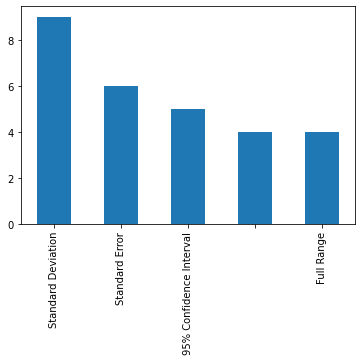

In [46]:
# Let's get an idea of the ranges here
bar = placebo_studies['outcome_spread'].value_counts().plot.bar()


In [47]:
import json

placebo_studies = studiesdf[studiesdf['placebo_group'] != 'NA']
# Get the results from the placebo group
# TODO: we really need to get the number of people for each group
def get_placebo_scores(outcomes, placebo_group):
    placebo_scores = []
    if 'OutcomeClass' in outcomes:
        for outcome_group in outcomes['OutcomeClass']:
            for measurement in outcome_group['OutcomeCategoryList']['OutcomeCategory'][0]['OutcomeMeasurementList']['OutcomeMeasurement']:
                if placebo_group == measurement['OutcomeMeasurementGroupId']: 
                    placebo_scores.append(measurement['OutcomeMeasurementValue'])
    
    return placebo_scores

def get_control_scores(outcomes, placebo_group):
    control_scores = []
    if 'OutcomeClass' in outcomes:
        for outcome_group in outcomes['OutcomeClass']:
            for measurement in outcome_group['OutcomeCategoryList']['OutcomeCategory'][0]['OutcomeMeasurementList']['OutcomeMeasurement']:
                if placebo_group != measurement['OutcomeMeasurementGroupId']: 
                    control_scores.append(measurement['OutcomeMeasurementValue'])
                    continue
    
    return control_scores

def get_control_ranges(outcomes, placebo_group): 
    control_ranges = []
    if 'OutcomeClass' in outcomes:
        for outcome_group in outcomes['OutcomeClass']:
            for measurement in outcome_group['OutcomeCategoryList']['OutcomeCategory'][0]['OutcomeMeasurementList']['OutcomeMeasurement']:
                if placebo_group != measurement['OutcomeMeasurementGroupId']:
                    has_spread_val = 'OutcomeMeasurementSpread' in measurement
                    has_range_vals = 'OutcomeMeasurementLowerLimit' in measurement
                    if not has_spread_val and not has_range_vals: 
                        control_ranges.append(-1)
                        continue
                    control_ranges.append(measurement['OutcomeMeasurementSpread'] if has_spread_val else (measurement['OutcomeMeasurementLowerLimit'], measurement['OutcomeMeasurementUpperLimit']))

    return control_ranges

def get_placebo_ranges(outcomes, placebo_group):
    placebo_ranges = []
    if 'OutcomeClass' in outcomes:
        for outcome_group in outcomes['OutcomeClass']:
            for measurement in outcome_group['OutcomeCategoryList']['OutcomeCategory'][0]['OutcomeMeasurementList']['OutcomeMeasurement']:
                if placebo_group == measurement['OutcomeMeasurementGroupId']:
                    has_spread_val = 'OutcomeMeasurementSpread' in measurement
                    has_range_vals = 'OutcomeMeasurementLowerLimit' in measurement
                    if not has_spread_val and not has_range_vals: 
                        placebo_ranges.append(-1)
                        continue
                    placebo_ranges.append(measurement['OutcomeMeasurementSpread'] if has_spread_val else (measurement['OutcomeMeasurementLowerLimit'], measurement['OutcomeMeasurementUpperLimit']))

    return placebo_ranges    

placebo_studies['placebo_scores'] = placebo_studies.apply(lambda x: get_placebo_scores(x.outcomes, x.placebo_group), axis=1)
placebo_studies['control_scores'] = placebo_studies.apply(lambda x: get_control_scores(x.outcomes, x.placebo_group), axis=1)
placebo_studies['control_ranges'] = placebo_studies.apply(lambda x: get_control_ranges(x.outcomes, x.placebo_group), axis=1)
placebo_studies['placebo_ranges'] = placebo_studies.apply(lambda x: get_placebo_ranges(x.outcomes, x.placebo_group), axis=1)


/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [48]:
import json

def get_placebo_no(participants, placebo_group): 
    placebo_subjects = -1
    if 'OutcomeDenom' in participants:
        for outcome_group in participants['OutcomeDenom']:
            for group in outcome_group['OutcomeDenomCountList']['OutcomeDenomCount']:
                if placebo_group == group['OutcomeDenomCountGroupId']:
                    placebo_subjects = group['OutcomeDenomCountValue']
    
    return placebo_subjects

def get_control_no(participants, placebo_group):
    control_subjects = -1
    if 'OutcomeDenom' in participants:
        for outcome_group in participants['OutcomeDenom']:
            for group in outcome_group['OutcomeDenomCountList']['OutcomeDenomCount']:
                if placebo_group != group['OutcomeDenomCountGroupId']:
                    control_subjects = group['OutcomeDenomCountValue']
    
    return control_subjects

placebo_studies['control_no'] = placebo_studies.apply(lambda x: get_control_no(x.outcome_subjects, x.placebo_group), axis=1)
placebo_studies['placebo_no'] = placebo_studies.apply(lambda x: get_placebo_no(x.outcome_subjects, x.placebo_group), axis=1)


/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
placebo_studies

,id,name,outcome_groups,drug,conditions,primary_outcomes,verified_date,responsible_party,type,type_description,...,outcome_measure_param,outcomes,outcome_subjects,placebo_group,placebo_scores,control_scores,control_ranges,placebo_ranges,control_no,placebo_no
0,NCT02926573,Perioperative Gabapentin Use In Head And Neck ...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Head and Neck Cancer, Acute Pain, Postoperati...",[{'PrimaryOutcomeMeasure': 'Change in Daily Na...,July 2018,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Median,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[1.59],[1.60],"[(0, 6.11)]","[(0, 5.84)]",44,46
1,NCT00414466,"A Randomized Double Blind, Placebo-controlled,...","[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Chronic Intractable Pain],[{'PrimaryOutcomeMeasure': 'Changes in a Pain ...,August 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[0.48],"[0.40, 0.10, -0.02]","[1.33, 0.99, 1.11]",[1.52],41,43
2,NCT00108550,Efficacy of Antidepressants in Chronic Back Pain,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Chronic Low Back Pain],[{'PrimaryOutcomeMeasure': 'Transformed Descri...,December 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[0.6683],[0.6988],"[(0.6463, 0.7512)]","[(0.6145, 0.7220)]",55,53
3,NCT02359110,Administration of Pre-Operative Gabapentin to ...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],[{'PrimaryOutcomeMeasure': 'NRS (Numerical Rat...,March 2018,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,...,Least Squares Mean,{'OutcomeClass': [{'OutcomeClassTitle': 'Hour ...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,"[3.4, 5.5, 5.8, 5.1]","[3.5, 5.4, 5.3, 5.7]","[(2.6, 4.5), (4.3, 6.5), (4.2, 6.5), (4.3, 7.2)]","[(2.5, 4.4), (4.3, 6.7), (4.4, 7.1), (3.4, 6.8)]",55,54
5,NCT00726999,Perioperative Use of Gabapentin To Decrease Op...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],[{'PrimaryOutcomeMeasure': 'Amount of Morphine...,March 2019,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,...,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[0.044],[0.064],[0.031],[0.017],32,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,NCT01678911,Efficacy of Gralise® for Chronic Pelvic Pain,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Irritable Bowel Syndrome, Ulcerative Colitis,...",[{'PrimaryOutcomeMeasure': 'McGill Pain Questi...,June 2015,{'ResponsiblePartyType': 'Principal Investigat...,Crossover Assignment,,...,Mean,{'OutcomeClass': [{'OutcomeClassTitle': 'chang...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,"[-0.34, 1.05]","[.04, .41]","[0, 0]","[1.78, 0.45]",1,4
115,NCT01506453,Therapeutic Interventions For Peripheral Neuro...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Acute Lymphoblastic Leukemia, Neuropathy, Neu...",[{'PrimaryOutcomeMeasure': 'Daily Total Dose o...,April 2019,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Mean,{'OutcomeClass': [{'OutcomeClassTitle': 'Day 1...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,"[0.27433, 0.31816, 0.27961, 0.35343, 0.37920, ...","[0.38267, 0.43685, 0.37281, 0.40384, 0.37662, ...","[0.28921, 0.33788, 0.32935, 0.32469, 0.31263, ...","[0.19299, 0.16012, 0.18509, 0.18688, 0.22471, ...",25,24
116,NCT00643760,Study PXN110448: A Dose-response Study of XP13...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Neuropathy, Diabetic]",[{'PrimaryOutcomeMeasure': 'C

In [50]:
placebo_studies = placebo_studies.drop_duplicates(subset=['id'])

In [51]:
def get_bad_ranges(control_ranges):
    return (len(control_ranges) == 1 and control_ranges == [-1]) or (len(control_ranges) == 0)

len(placebo_studies[placebo_studies['control_ranges'].apply(get_bad_ranges)])

4

<AxesSubplot:>

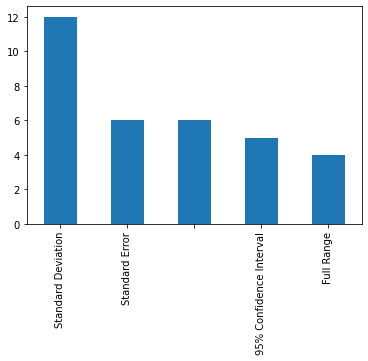

In [52]:
# Let's take a look at the types of mesaurements and see if we can't group them 

placebo_studies['outcome_spread'].value_counts().plot.bar()
# Looks pretty good -> only 3-4 options depending on how you want to process it 

In [53]:
placebo_studies[placebo_studies['outcome_spread'] == 'Standard Error']

,id,name,outcome_groups,drug,conditions,primary_outcomes,verified_date,responsible_party,type,type_description,...,outcome_measure_param,outcomes,outcome_subjects,placebo_group,placebo_scores,control_scores,control_ranges,placebo_ranges,control_no,placebo_no
10,NCT01210079,Hyperalgesia in Methadone-Maintained Patients:...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Opioid-Induced Hyperalgesia],[{'PrimaryOutcomeMeasure': 'Change in Pain Thr...,February 2012,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,...,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[-3.49],[2.95],[2.41],[2.85],10,16
18,NCT00619476,Study PXN110748: An Efficacy and Safety Study ...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Neuralgia, Postherpetic]",[{'PrimaryOutcomeMeasure': 'Change From Baseli...,January 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Least Squares Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[-1.66],"[-2.47, -2.36, -2.72]","[0.204, 0.237, 0.227]",[0.216],87,95
29,NCT01668667,"A Randomized, Double-Blind, Placebo-Controlled...","[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Restless Legs Syndrome],[{'PrimaryOutcomeMeasure': 'The Change From Ba...,November 2014,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG003,[-9.93],"[-12.50, -12.54, -11.48]","[0.745, 0.764, 0.767]",[0.753],111,117
35,NCT00643760,Study PXN110448: A Dose-response Study of XP13...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Neuropathy, Diabetic]",[{'PrimaryOutcomeMeasure': 'Change From Baseli...,January 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Least Squares Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[-2.08],"[-2.43, -2.10, -2.63, -1.65]","[0.274, 0.289, 0.202, 0.266]",[0.196],66,120
38,NCT00748098,"Study RXP110908, a Polysomnography Study of GS...","[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Restless Legs Syndrome, Restless Legs Syndrom...",[{'PrimaryOutcomeMeasure': 'Adjusted Mean Chan...,January 2013,{'ResponsiblePartyType': 'Sponsor'},Crossover Assignment,,...,Least Squares Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[-6.02],[-32.02],[5.020],[4.986],121,123
41,NCT01332318,"A Randomized, Double Blind, Active- and Placeb...","[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Restless Legs Syndrome],[{'PrimaryOutcomeMeasure': 'Change From Baseli...,June 2011,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,Least Squares Mean,{'OutcomeClass': [{'OutcomeCategoryList': {'Ou...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[-0.10],"[0.15, 0.15, 0.16]","[0.06, 0.06, 0.06]",[0.06],28,30


In [54]:
# Get the standard deviation for each one of the rows

import math

def get_sd(outcome_spread, ranges, obs):
    if outcome_spread == 'Standard Error':
        return [(math.sqrt(int(obs)) * float(x)) for x in ranges]
    
#     if outcome_spread == '95% Confidence Interval':
#         return [(math.sqrt(int(obs)) * (float(x[1]) - float(x[0])) / 3.92) for x in ranges]
    
    if outcome_spread == 'Standard Deviation':
        return ranges
    
    return -1

placebo_studies['control_sd_ranges'] = placebo_studies.apply(lambda x: get_sd(x.outcome_spread, x.control_ranges, x.control_no), axis=1)
placebo_studies['placebo_sd_ranges'] = placebo_studies.apply(lambda x: get_sd(x.outcome_spread, x.placebo_ranges, x.placebo_no), axis=1)
placebo_studies

/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,name,outcome_groups,drug,conditions,primary_outcomes,verified_date,responsible_party,type,type_description,...,outcome_subjects,placebo_group,placebo_scores,control_scores,control_ranges,placebo_ranges,control_no,placebo_no,control_sd_ranges,placebo_sd_ranges
0,NCT02926573,Perioperative Gabapentin Use In Head And Neck ...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Head and Neck Cancer, Acute Pain, Postoperati...",[{'PrimaryOutcomeMeasure': 'Change in Daily Na...,July 2018,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[1.59],[1.60],"[(0, 6.11)]","[(0, 5.84)]",44,46,-1,-1
1,NCT00414466,"A Randomized Double Blind, Placebo-controlled,...","[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Chronic Intractable Pain],[{'PrimaryOutcomeMeasure': 'Changes in a Pain ...,August 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[0.48],"[0.40, 0.10, -0.02]","[1.33, 0.99, 1.11]",[1.52],41,43,"[1.33, 0.99, 1.11]",[1.52]
2,NCT00108550,Efficacy of Antidepressants in Chronic Back Pain,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Chronic Low Back Pain],[{'PrimaryOutcomeMeasure': 'Transformed Descri...,December 2013,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,[0.6683],[0.6988],"[(0.6463, 0.7512)]","[(0.6145, 0.7220)]",55,53,-1,-1
3,NCT02359110,Administration of Pre-Operative Gabapentin to ...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],[{'PrimaryOutcomeMeasure': 'NRS (Numerical Rat...,March 2018,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,"[3.4, 5.5, 5.8, 5.1]","[3.5, 5.4, 5.3, 5.7]","[(2.6, 4.5), (4.3, 6.5), (4.2, 6.5), (4.3, 7.2)]","[(2.5, 4.4), (4.3, 6.7), (4.4, 7.1), (3.4, 6.8)]",55,54,-1,-1
5,NCT00726999,Perioperative Use of Gabapentin To Decrease Op...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],[{'PrimaryOutcomeMeasure': 'Amount of Morphine...,March 2019,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[0.044],[0.064],[0.031],[0.017],32,31,[0.031],[0.017]
7,NCT00793910,Oral Gabapentin Versus Placebo for Treatment o...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],"[{'PrimaryOutcomeMeasure': 'Level of Pain', 'P...",July 2014,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[4.09],[3.85],[2.05],[2.38],41,41,[2.05],[2.38]
8,NCT02703259,Single Dose Preoperative Gabapentin Use in Min...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,"[Pain, Postoperative]",[{'PrimaryOutcomeMeasure': 'Narcotic Use at 24...,May 2020,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[175.0],[158.8],[109.6],[162.5],68,61,[109.6],[162.5]
9,NCT01680549,Pain Control With Total Knee Replacement: Does...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Postoperative Pain],[{'PrimaryOutcomeMeasure': 'Patient Pain Score...,January 2017,{'ResponsiblePartyType': 'Sponsor'},Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG000,"[33.6, 34.9, 38.0]","[40.0, 46.3, 39.6]","[26.1, 30.5, 18.8]","[23.3, 26.6, 15.9]",20,17,"[26.1, 30.5, 18.8]","[23.3, 26.6, 15.9]"
10,NCT01210079,Hyperalgesia in Methadone-Maintained Patients:...,"[{'OutcomeGroupId': 'OG000', 'OutcomeGroupTitl...",gabapentin,[Opioid-Induced Hyperalgesia],[{'PrimaryOutcomeMeasure': 'Change in Pain Thr...,February 2012,{'ResponsiblePartyType': 'Principal Investigat...,Parallel Assignment,,...,{'OutcomeDenom': [{'OutcomeDenomUnits': 'Parti...,OG001,[-3.49],[2.95],[2.41

In [55]:
# Now let's take a shot at making the effectiveness score - I wonder if we can just take the p-value
# from each of the studies - I can't find the p-value for some but I can use one for others??
# I think getting the range and doing a t-test for each one of the groups - just our own p-value, use the other 
# p-value for sanity check

# For the IQR ranges -> we can estimate the distribution as normal and do SD = IQR/1.35 and run eveything from there

# We also need the number of observations here - so the number of patients for the study 
def get_p_value(placebo_scores, control_scores, control_sd_ranges, placebo_sd_ranges, control_no, placebo_no):
    # What if there is a score imbalance?? can't risk it right now - we need to do strict matching or 1:*
    p_vals = []
    if len(placebo_scores) != len(control_scores) and len(placebo_scores) != 1:
        return [-1]
        
    if len(control_scores) != len(control_sd_ranges) or len(placebo_scores) != len(placebo_sd_ranges):
        return [-2]
    
    
    for i in range(len(control_scores)):
        placebo_index = i if i < len(placebo_scores) else 0        
        p_val = stats.ttest_ind_from_stats(mean1=float(control_scores[i]), std1=float(control_sd_ranges[i]), nobs1=int(control_no),
                                  mean2=float(placebo_scores[placebo_index]), std2=float(placebo_sd_ranges[placebo_index]), nobs2=int(placebo_no)).pvalue
        p_vals.append(p_val)
    
    return p_vals

temp = placebo_studies[placebo_studies['outcome_spread'] == 'Standard Deviation']
temp.apply(lambda x: get_p_value(x.placebo_scores, x.control_scores, x.control_sd_ranges, x.placebo_sd_ranges, x.control_no, x.placebo_no), axis=1)
    

1     [0.7984300486804039, 0.18054242812252252, 0.09...
5                                [0.002451395599569084]
7                                  [0.6260177839799328]
8                                   [0.504229768942563]
9     [0.44038625913776963, 0.23795630669235976, 0.7...
20                                [0.49476163219039715]
27              [0.8607602133461854, 0.292998086240382]
32                                                 [-1]
37                                                 [-1]
39                              [0.0074018084253453026]
74          [0.3211593809628029, 0.0003251805363916385]
76                                                 [-1]
dtype: object

In [81]:
temp.apply(lambda x: print(x.id))

AttributeError: 'Series' object has no attribute 'id'